# Notebook Introduction
This notebook covers my implementation for classifying twitter tweets as disaster/non-disaster. I've developed a simple distilBERT classification model which achieved a public score of 0.82 on the Kaggle Leaderboard.

Other things covered in this notebook is training on GPUs, and parallelizing training on GPUs.

Please do leave comments if some part of the code is unclear - would like to improve these notebooks and hopefully have someone else learn through my work :)

# Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
import re

# Loading the Data

In [2]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")

# Load BERT

Loading the BERT model. I've used the DistilBert model in this case to reduce computation time.

In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

# Load pretrained 

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Load pretrained model with classification head
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2  # binary classification: disaster / non-disaster
)



2025-09-15 10:24:00.621980: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757931840.806737      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757931840.869295      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Pre-processing Text

I've highlighted some of exploratory analysis for this dataset. I noticed a lot of tweets contained mentions, URLs and hashtags. Since BERT would interpret @BBCNews or other accounts as separate words, and likely would not have a lot of these available in its vocabulary, I generalised mentions and URLs to tags \<URL\>, \<MENTION\>. While the URL/Mention itself may not provide a lot of useful information to the model, the presence/absence of it could help the model to classify between disaster/non-disaster.
Lastly, I removed punctuations from the tweets as I did not think it provided any useful information to the model.

For the future, I believe we could do some study on the length of the tweets, number of punctuations (maybe exclamation marks could indicate adversity) and create features to feed into the model for the same.

## Check tokenized text created by BERT

In [4]:
df_train['tokenized'] = df_train['text'].apply((lambda x: tokenizer.tokenize(x)))

In [5]:
df_train.head()

,id,keyword,location,text,target,tokenized
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[our, deeds, are, the, reason, of, this, #, ea..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ron, ##ge, sas, ##k, ..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[all, residents, asked, to, ', shelter, in, pl..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[13, ,, 000, people, receive, #, wild, ##fires..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[just, got, sent, this, photo, from, ruby, #, ..."


In [6]:
(df_train.head(10)  # adjust number of rows
   .style.set_properties(subset=['text'],  # replace 'text' with your tweet column name
                         **{'white-space': 'pre-wrap', 'word-wrap': 'break-word'}))

,id,keyword,location,text,target,tokenized
0,1,nan,nan,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,"['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', '#', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']"
1,4,nan,nan,Forest fire near La Ronge Sask. Canada,1,"['forest', 'fire', 'near', 'la', 'ron', '##ge', 'sas', '##k', '.', 'canada']"
2,5,nan,nan,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,"['all', 'residents', 'asked', 'to', ""'"", 'shelter', 'in', 'place', ""'"", 'are', 'being', 'notified', 'by', 'officers', '.', 'no', 'other', 'evacuation', 'or', 'shelter', 'in', 'place', 'orders', 'are', 'expected']"
3,6,nan,nan,"13,000 people receive #wildfires evacuation orders in California",1,"['13', ',', '000', 'people', 'receive', '#', 'wild', '##fires', 'evacuation', 'orders', 'in', 'california']"
4,7,nan,nan,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,"['just', 'got', 'sent', 'this', 'photo', 'from', 'ruby', '#', 'alaska', 'as', 'smoke', 'from', '#', 'wild', '##fires', 'pour', '##s', 'into', 'a', 'school']"
5,8,nan,nan,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1,"['#', 'rocky', '##fire', 'update', '=', '>', 'california', 'h', '##wy', '.', '20', 'closed', 'in', 'both', 'directions', 'due', 'to', 'lake', 'county', 'fire', '-', '#', 'caf', '##ire', '#', 'wild', '##fires']"
6,10,nan,nan,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1,"['#', 'flood', '#', 'disaster', 'heavy', 'rain', 'causes', 'flash', 'flooding', 'of', 'streets', 'in', 'mani', '##tou', ',', 'colorado', 'springs', 'areas']"
7,13,nan,nan,I'm on top of the hill and I can see a fire in the woods...,1,"['i', ""'"", 'm', 'on', 'top', 'of', 'the', 'hill', 'and', 'i', 'can', 'see', 'a', 'fire', 'in', 'the', 'woods', '.', '.', '.']"
8,14,nan,nan,There's an emergency evacuation happening now in the building across the street,1,"['there', ""'"", 's', 'an', 'emergency', 'evacuation', 'happening', 'now', 'in', 'the', 'building', 'across', 'the', 'street']"
9,15,nan,nan,I'm afraid that the tornado is coming to our area...,1,"['i', ""'"", 'm', 'afraid', 'that', 'the', 'tornado', 'is', 'coming', 'to', 'our', 'area', '.', '.', '.']"


## Check URLs in text

In [7]:
def check_url(text):
    url_pattern = re.compile(r'http[s]?://\S+|www\.\S+')
    return bool(url_pattern.search(text))

In [8]:
df_train['contain_url'] = df_train['text'].apply(lambda x: check_url(x))

In [9]:
# df_train[df_train['contain_url'] == 1]

(df_train[df_train['contain_url'] == 1].head(10)  # adjust number of rows
   .style.set_properties(subset=['text'],  # replace 'text' with your tweet column name
                         **{'white-space': 'pre-wrap', 'word-wrap': 'break-word'}))

,id,keyword,location,text,target,tokenized,contain_url
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C,1,"['@', 'bbc', '##mt', '##d', 'wholesale', 'markets', 'ab', '##laze', 'http', ':', '/', '/', 't', '.', 'co', '/', 'l', '##hy', '##x', '##eo', '##hy', '##6', '##c']",True
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw,0,"['we', 'always', 'try', 'to', 'bring', 'the', 'heavy', '.', '#', 'metal', '#', 'rt', 'http', ':', '/', '/', 't', '.', 'co', '/', 'yao', '##1', '##e', '##0', '##x', '##ng', '##w']",True
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi,1,"['#', 'african', '##ba', '##ze', ':', 'breaking', 'news', ':', 'nigeria', 'flag', 'set', 'ab', '##laze', 'in', 'aba', '.', 'http', ':', '/', '/', 't', '.', 'co', '/', '2', '##nn', '##db', '##g', '##wy', '##ei']",True
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N,0,"['on', 'plus', 'side', 'look', 'at', 'the', 'sky', 'last', 'night', 'it', 'was', 'ab', '##laze', 'http', ':', '/', '/', 't', '.', 'co', '/', 'q', '##q', '##sms', '##ha', '##j', '##3', '##n']",True
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3ImaomknnA,1,"['in', '##ec', 'office', 'in', 'ab', '##ia', 'set', 'ab', '##laze', '-', 'http', ':', '/', '/', 't', '.', 'co', '/', '3', '##ima', '##om', '##k', '##nna']",True
38,56,ablaze,nan,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ablaze: SANTA CRUZ ÛÓ Head of the St Elizabeth Police Superintende... http://t.co/wDUEaj8Q4J,1,"['barbados', '#', 'bridget', '##own', 'jamaica', 'u', '##o', 'two', 'cars', 'set', 'ab', '##laze', ':', 'santa', 'cruz', 'u', '##o', 'head', 'of', 'the', 'st', 'elizabeth', 'police', 'super', '##int', '##end', '##e', '.', '.', '.', 'http', ':', '/', '/', 't', '.', 'co', '/', 'w', '##due', '##aj', '##8', '##q', '##4', '##j']",True
40,59,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw,0,"['check', 'these', 'out', ':', 'http', ':', '/', '/', 't', '.', 'co', '/', 'roi', '##2', '##ns', '##me', '##j', '##j', 'http', ':', '/', '/', 't', '.', 'co', '/', '3', '##t', '##j', '##8', '##z', '##jin', '##21', 'http', ':', '/', '/', 't', '.', 'co', '/', 'yd', '##ui', '##x', '##ef', '##ipe', 'http', ':', '/', '/', 't', '.', 'co', '/', 'l', '##xt', '##j', '##c', '##8', '##7', '##k', '##ls', '#', 'ns', '##f', '##w']",True
44,64,ablaze,nan,I wanted to set Chicago ablaze with my preaching... But not my hotel! http://t.co/o9qknbfOFX,0,"['i', 'wanted', 'to', 'set', 'chicago', 'ab', '##laze', 'with', 'my', 'preaching', '.', '.', '.', 'but', 'not', 'my', 'hotel', '!', 'http', ':', '/', '/', 't', '.', 'co', '/', 'o', '##9', '##q', '##k', '##nb', '##fo', '##f', '##x']",True
45,65,ablaze,nan,I gained 3 followers in the last week. You? Know your stats and grow with http://t.co/TIyUliF5c6,0,"['i', 'gained', '3', 'followers', 'in', 'the', 'last', 'week', '.', 'you', '?', 'know', 'your', 'stats', 'and', 'grow', 'with', 'http', ':', '/', '/', 't', '.', 'co', '/', 'ti', '##yu', '##li', '##f', '##5', '##c', '##6']",True
46,66,ablaze,"GREENSBORO,NORTH CAROLINA",How the West was burned: Thousands of wildfires ablaze in California alone http://t.co/vl5TBR3wbr,1,"['how', 'the', 'west', 'was', 'burned', ':', 'thousands', 'of', 'wild', '##fires', 'ab', '##laze', 'in', 'california', 'alone', 'http', ':', '/', '/', 't', '.', 'co', '/', 'v', '##l', '##5', '##t', '##br', '##3', '##w', '##br']",True


In [10]:
df_train[df_train['contain_url'] == 1]['target'].value_counts()

target
1    2172
0    1799
Name: count, dtype: int64

In [11]:
# Here We also Use Regular Expressions to Remove URLs from Text or Whole Corpus.
def remove_url(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'[URL]', text)

In [12]:
df_train['cleaned_text'] = df_train['text'].apply(lambda x: remove_url(x))

In [13]:
# df_train[df_train['contain_url'] == 1]

(df_train[df_train['contain_url'] == 1].head(10)  # adjust number of rows
   .style.set_properties(subset=['text'],  # replace 'text' with your tweet column name
                         **{'white-space': 'pre-wrap', 'word-wrap': 'break-word'}))

,id,keyword,location,text,target,tokenized,contain_url,cleaned_text
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C,1,"['@', 'bbc', '##mt', '##d', 'wholesale', 'markets', 'ab', '##laze', 'http', ':', '/', '/', 't', '.', 'co', '/', 'l', '##hy', '##x', '##eo', '##hy', '##6', '##c']",True,@bbcmtd Wholesale Markets ablaze [URL]
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw,0,"['we', 'always', 'try', 'to', 'bring', 'the', 'heavy', '.', '#', 'metal', '#', 'rt', 'http', ':', '/', '/', 't', '.', 'co', '/', 'yao', '##1', '##e', '##0', '##x', '##ng', '##w']",True,We always try to bring the heavy. #metal #RT [URL]
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi,1,"['#', 'african', '##ba', '##ze', ':', 'breaking', 'news', ':', 'nigeria', 'flag', 'set', 'ab', '##laze', 'in', 'aba', '.', 'http', ':', '/', '/', 't', '.', 'co', '/', '2', '##nn', '##db', '##g', '##wy', '##ei']",True,#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. [URL]
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N,0,"['on', 'plus', 'side', 'look', 'at', 'the', 'sky', 'last', 'night', 'it', 'was', 'ab', '##laze', 'http', ':', '/', '/', 't', '.', 'co', '/', 'q', '##q', '##sms', '##ha', '##j', '##3', '##n']",True,On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE [URL]
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3ImaomknnA,1,"['in', '##ec', 'office', 'in', 'ab', '##ia', 'set', 'ab', '##laze', '-', 'http', ':', '/', '/', 't', '.', 'co', '/', '3', '##ima', '##om', '##k', '##nna']",True,INEC Office in Abia Set Ablaze - [URL]
38,56,ablaze,nan,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ablaze: SANTA CRUZ ÛÓ Head of the St Elizabeth Police Superintende... http://t.co/wDUEaj8Q4J,1,"['barbados', '#', 'bridget', '##own', 'jamaica', 'u', '##o', 'two', 'cars', 'set', 'ab', '##laze', ':', 'santa', 'cruz', 'u', '##o', 'head', 'of', 'the', 'st', 'elizabeth', 'police', 'super', '##int', '##end', '##e', '.', '.', '.', 'http', ':', '/', '/', 't', '.', 'co', '/', 'w', '##due', '##aj', '##8', '##q', '##4', '##j']",True,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ablaze: SANTA CRUZ ÛÓ Head of the St Elizabeth Police Superintende... [URL]
40,59,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw,0,"['check', 'these', 'out', ':', 'http', ':', '/', '/', 't', '.', 'co', '/', 'roi', '##2', '##ns', '##me', '##j', '##j', 'http', ':', '/', '/', 't', '.', 'co', '/', '3', '##t', '##j', '##8', '##z', '##jin', '##21', 'http', ':', '/', '/', 't', '.', 'co', '/', 'yd', '##ui', '##x', '##ef', '##ipe', 'http', ':', '/', '/', 't', '.', 'co', '/', 'l', '##xt', '##j', '##c', '##8', '##7', '##k', '##ls', '#', 'ns', '##f', '##w']",True,Check these out: [URL] [URL] [URL] [URL] #nsfw
44,64,ablaze,nan,I wanted to set Chicago ablaze with my preaching... But not my hotel! http://t.co/o9qknbfOFX,0,"['i', 'wanted', 'to', 'set', 'chicago', 'ab', '##laze', 'with', 'my', 'preaching', '.', '.', '.', 'but', 'not', 'my', 'hotel', '!', 'http', ':', '/', '/', 't', '.', 'co', '/', 'o', '##9', '##q', '##k', '##nb', '##fo', '##f', '##x']",True,I wanted to set Chicago ablaze with my preaching... But not my hotel! [URL]
45,65,ablaze,nan,I gained 3 followers in the last week. You? Know your stats and grow with http://t.co/TIyUliF5c6,0,"['i', 'gained', '3', 'followers', 'in', 'the', 'last', 'week', '.', 'you', '?', 'know', 'your', 'stats', 'and', 'grow', 'with', 'http', ':', '/', '/', 't', '.', 'co', '/', 'ti', '##yu', '##li', '##f', '##5', '##c', '##6']",True,I gained 3 followers in the last week. You? Know your stats and grow with [URL]
46,66,ablaze,"GREENSBORO,NORTH CAROLINA",How the West was burned: Thousands of wildfires ablaze in California alone http://t.co/vl5TBR3wbr,1,"['how', 'the', 'west', 'was

## Check mentions

In [14]:
def contains_mention(text):
    mention_pattern = re.compile(r'@[A-Za-z_]\w*')
    return bool(mention_pattern.search(text))

In [15]:
df_train['contain_mentions'] = df_train['text'].apply(lambda x: contains_mention(x))

In [16]:
df_train[df_train['contain_mentions'] == 1]['target'].value_counts()

target
0    1334
1     658
Name: count, dtype: int64

In [17]:
# Here We also Use Regular Expressions to Remove URLs from Text or Whole Corpus.
def remove_mentions(text):
    pattern = re.compile(r'@[A-Za-z_]\w*')
    return pattern.sub(r'[MENTION]', text)

In [18]:
df_train['cleaned_text'] = df_train['cleaned_text'].apply(lambda x: remove_mentions(x))

In [19]:
(df_train[df_train['contain_mentions'] == 1].head(10)  # adjust number of rows
   .style.set_properties(subset=['text'],  # replace 'text' with your tweet column name
                         **{'white-space': 'pre-wrap', 'word-wrap': 'break-word'}))

,id,keyword,location,text,target,tokenized,contain_url,cleaned_text,contain_mentions
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C,1,"['@', 'bbc', '##mt', '##d', 'wholesale', 'markets', 'ab', '##laze', 'http', ':', '/', '/', 't', '.', 'co', '/', 'l', '##hy', '##x', '##eo', '##hy', '##6', '##c']",True,[MENTION] Wholesale Markets ablaze [URL],True
36,54,ablaze,Pretoria,@PhDSquares #mufc they've built so much hype around new acquisitions but I doubt they will set the EPL ablaze this season.,0,"['@', 'phd', '##s', '##qua', '##res', '#', 'mu', '##fc', 'they', ""'"", 've', 'built', 'so', 'much', 'h', '##ype', 'around', 'new', 'acquisitions', 'but', 'i', 'doubt', 'they', 'will', 'set', 'the', 'ep', '##l', 'ab', '##laze', 'this', 'season', '.']",False,[MENTION] #mufc they've built so much hype around new acquisitions but I doubt they will set the EPL ablaze this season.,True
43,63,ablaze,nan,SOOOO PUMPED FOR ABLAZE ???? @southridgelife,0,"['soo', '##oo', 'pumped', 'for', 'ab', '##laze', '?', '?', '?', '?', '@', 'south', '##ridge', '##life']",False,SOOOO PUMPED FOR ABLAZE ???? [MENTION],True
54,78,ablaze,Abuja,Noches El-Bestia '@Alexis_Sanchez: happy to see my teammates and training hard ?? goodnight gunners.?????? http://t.co/uc4j4jHvGR',0,"['no', '##ches', 'el', '-', 'best', '##ia', ""'"", '@', 'alexis', '_', 'sanchez', ':', 'happy', 'to', 'see', 'my', 'teammates', 'and', 'training', 'hard', '?', '?', 'goodnight', 'gunners', '.', '?', '?', '?', '?', '?', '?', 'http', ':', '/', '/', 't', '.', 'co', '/', 'uc', '##4', '##j', '##4', '##j', '##h', '##v', '##gr', ""'""]",True,Noches El-Bestia '[MENTION]: happy to see my teammates and training hard ?? goodnight gunners.?????? [URL],True
63,91,ablaze,"Concord, CA",@Navista7 Steve these fires out here are something else! California is a tinderbox - and this clown was setting my 'hood ablaze @News24680,1,"['@', 'na', '##vis', '##ta', '##7', 'steve', 'these', 'fires', 'out', 'here', 'are', 'something', 'else', '!', 'california', 'is', 'a', 'tin', '##der', '##box', '-', 'and', 'this', 'clown', 'was', 'setting', 'my', ""'"", 'hood', 'ab', '##laze', '@', 'news', '##24', '##6', '##80']",False,[MENTION] Steve these fires out here are something else! California is a tinderbox - and this clown was setting my 'hood ablaze [MENTION],True
65,93,ablaze,Birmingham,@nxwestmidlands huge fire at Wholesale markets ablaze http://t.co/rwzbFVNXER,1,"['@', 'n', '##x', '##west', '##mi', '##dl', '##ands', 'huge', 'fire', 'at', 'wholesale', 'markets', 'ab', '##laze', 'http', ':', '/', '/', 't', '.', 'co', '/', 'r', '##w', '##z', '##bf', '##vn', '##x', '##er']",True,[MENTION] huge fire at Wholesale markets ablaze [URL],True
66,95,ablaze,San Francisco,@ablaze what time does your talk go until? I don't know if I can make it due to work.,0,"['@', 'ab', '##laze', 'what', 'time', 'does', 'your', 'talk', 'go', 'until', '?', 'i', 'don', ""'"", 't', 'know', 'if', 'i', 'can', 'make', 'it', 'due', 'to', 'work', '.']",False,[MENTION] what time does your talk go until? I don't know if I can make it due to work.,True
75,109,accident,nan,RT @SleepJunkies: Sleeping pills double your risk of a car accident http://t.co/7s9Nm1fiCT,0,"['rt', '@', 'sleep', '##jun', '##kie', '##s', ':', 'sleeping', 'pills', 'double', 'your', 'risk', 'of', 'a', 'car', 'accident', 'http', ':', '/', '/', 't', '.', 'co', '/', '7', '##s', '##9', '##n', '##m', '##1', '##fi', '##ct']",True,RT [MENTION]: Sleeping pills double your risk of a car accident [URL],True
97,139,accident,"Hagerstown, MD",#BREAKING: there was a deadly motorcycle car accident that happened to #Hagerstown today. I'll have more details at 5 @Your4State. #WHAG,1,"['#', 'breaking', ':', 'there', 'was', 'a', 'deadly', 'motorcycle', 'car', 'accident', 'that', 'happened', 'to', '#', 'ha', '##gers', '##town', 'today', '.', 'i', ""'"", 'll', 'have', 'more', 'details', 'at', '5', '@', 'your', '##4', '##sta', '##te', '.', '#', 'w', '##ha', '##g']",False,#BREAKING: th

## Clean text to remove non-alphanumeric characters

In [20]:
import re

def clean_text(text):
    return re.sub(r'[^A-Za-z0-9 ]+', '', text)

In [21]:
df_train['cleaned_text'] = df_train['cleaned_text'].apply(clean_text)

In [22]:
df_train['cleaned_tokenized'] = df_train['cleaned_text'].apply((lambda x: tokenizer.tokenize(x)))

In [23]:
(df_train[df_train['contain_url'] == 1].head(10)  # adjust number of rows
   .style.set_properties(subset=['text'],  # replace 'text' with your tweet column name
                         **{'white-space': 'pre-wrap', 'word-wrap': 'break-word'}))

,id,keyword,location,text,target,tokenized,contain_url,cleaned_text,contain_mentions,cleaned_tokenized
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C,1,"['@', 'bbc', '##mt', '##d', 'wholesale', 'markets', 'ab', '##laze', 'http', ':', '/', '/', 't', '.', 'co', '/', 'l', '##hy', '##x', '##eo', '##hy', '##6', '##c']",True,MENTION Wholesale Markets ablaze URL,True,"['mention', 'wholesale', 'markets', 'ab', '##laze', 'ur', '##l']"
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw,0,"['we', 'always', 'try', 'to', 'bring', 'the', 'heavy', '.', '#', 'metal', '#', 'rt', 'http', ':', '/', '/', 't', '.', 'co', '/', 'yao', '##1', '##e', '##0', '##x', '##ng', '##w']",True,We always try to bring the heavy metal RT URL,False,"['we', 'always', 'try', 'to', 'bring', 'the', 'heavy', 'metal', 'rt', 'ur', '##l']"
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi,1,"['#', 'african', '##ba', '##ze', ':', 'breaking', 'news', ':', 'nigeria', 'flag', 'set', 'ab', '##laze', 'in', 'aba', '.', 'http', ':', '/', '/', 't', '.', 'co', '/', '2', '##nn', '##db', '##g', '##wy', '##ei']",True,AFRICANBAZE Breaking newsNigeria flag set ablaze in Aba URL,False,"['african', '##ba', '##ze', 'breaking', 'news', '##nig', '##eria', 'flag', 'set', 'ab', '##laze', 'in', 'aba', 'ur', '##l']"
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N,0,"['on', 'plus', 'side', 'look', 'at', 'the', 'sky', 'last', 'night', 'it', 'was', 'ab', '##laze', 'http', ':', '/', '/', 't', '.', 'co', '/', 'q', '##q', '##sms', '##ha', '##j', '##3', '##n']",True,On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE URL,False,"['on', 'plus', 'side', 'look', 'at', 'the', 'sky', 'last', 'night', 'it', 'was', 'ab', '##laze', 'ur', '##l']"
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3ImaomknnA,1,"['in', '##ec', 'office', 'in', 'ab', '##ia', 'set', 'ab', '##laze', '-', 'http', ':', '/', '/', 't', '.', 'co', '/', '3', '##ima', '##om', '##k', '##nna']",True,INEC Office in Abia Set Ablaze URL,False,"['in', '##ec', 'office', 'in', 'ab', '##ia', 'set', 'ab', '##laze', 'ur', '##l']"
38,56,ablaze,nan,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ablaze: SANTA CRUZ ÛÓ Head of the St Elizabeth Police Superintende... http://t.co/wDUEaj8Q4J,1,"['barbados', '#', 'bridget', '##own', 'jamaica', 'u', '##o', 'two', 'cars', 'set', 'ab', '##laze', ':', 'santa', 'cruz', 'u', '##o', 'head', 'of', 'the', 'st', 'elizabeth', 'police', 'super', '##int', '##end', '##e', '.', '.', '.', 'http', ':', '/', '/', 't', '.', 'co', '/', 'w', '##due', '##aj', '##8', '##q', '##4', '##j']",True,Barbados Bridgetown JAMAICA Two cars set ablaze SANTA CRUZ Head of the St Elizabeth Police Superintende URL,False,"['barbados', 'bridget', '##own', 'jamaica', 'two', 'cars', 'set', 'ab', '##laze', 'santa', 'cruz', 'head', 'of', 'the', 'st', 'elizabeth', 'police', 'super', '##int', '##end', '##e', 'ur', '##l']"
40,59,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw,0,"['check', 'these', 'out', ':', 'http', ':', '/', '/', 't', '.', 'co', '/', 'roi', '##2', '##ns', '##me', '##j', '##j', 'http', ':', '/', '/', 't', '.', 'co', '/', '3', '##t', '##j', '##8', '##z', '##jin', '##21', 'http', ':', '/', '/', 't', '.', 'co', '/', 'yd', '##ui', '##x', '##ef', '##ipe', 'http', ':', '/', '/', 't', '.', 'co', '/', 'l', '##xt', '##j', '##c', '##8', '##7', '##k', '##ls', '#', 'ns', '##f', '##w']",True,Check these out URL URL URL URL nsfw,False,"['check', 'these', 'out', 'ur', '##l', 'ur', '##l', 'ur', '##l', 'ur', '##l', 'ns', '##f', '##w']"
44,64,ablaze,nan,I wanted to set Chicago ablaze with my preaching... But not my hotel! http://t.co/o9qknbfOFX,0,"['i', 'wanted', 'to', 'set', 'chicago', 'ab', '##laze', 'with', 'my', 'preaching', '.', '.', '.', 'but', 

## Analyse pre-processing
Below I create some visualizations to see if there's any difference between the top tokens that appear in disaster vs non-disaster tweets. The first visualization was including a lot of stop words and common words, so I later analysed the log-odds of the words and could see clear distinctions between top words for disaster tweets vs non-disaster tweets. BERT initializes these words with weights, so common words would show up less anyways and there's no need to handle these words

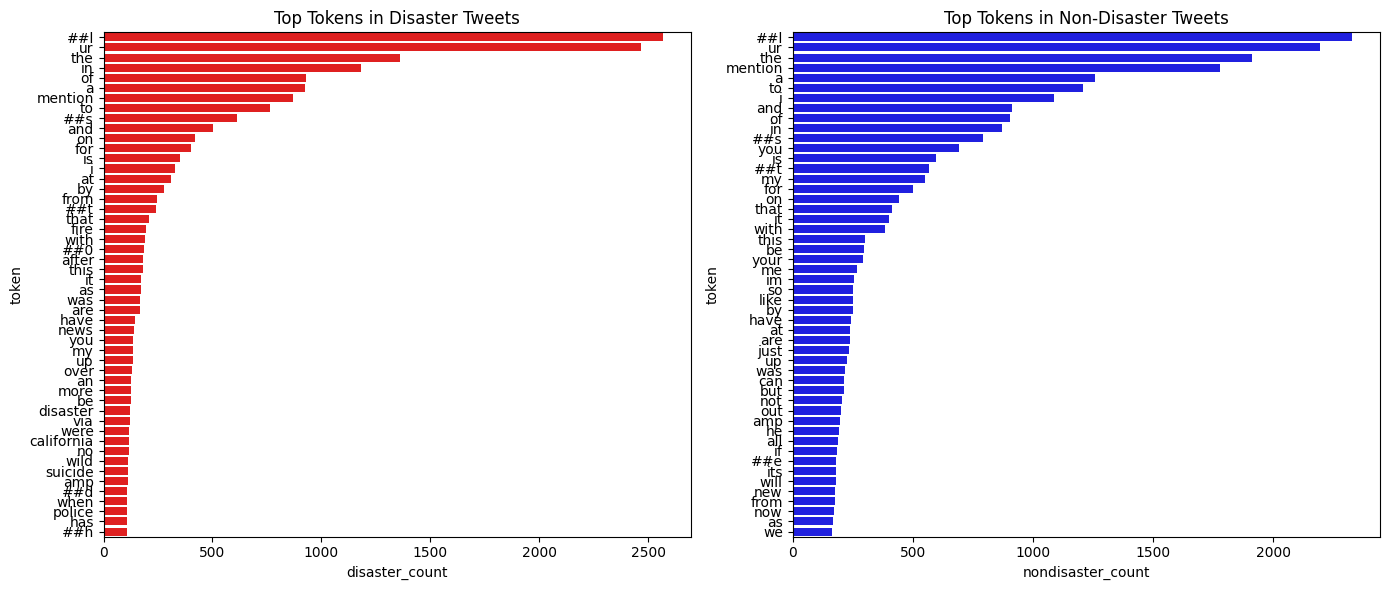

In [24]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Separate token lists by class
tokens_disaster = df_train[df_train['target'] == 1]['cleaned_tokenized'].explode()
tokens_nondisaster = df_train[df_train['target'] == 0]['cleaned_tokenized'].explode()

# Count token frequencies
disaster_counts = Counter(tokens_disaster)
nondisaster_counts = Counter(tokens_nondisaster)

# Convert to DataFrames
df_disaster = pd.DataFrame(disaster_counts.items(), columns=['token', 'disaster_count'])
df_nondisaster = pd.DataFrame(nondisaster_counts.items(), columns=['token', 'nondisaster_count'])

# Merge the two for comparison
token_dist = pd.merge(df_disaster, df_nondisaster, on='token', how='outer').fillna(0)

# Optionally, sort by most frequent in either class
token_dist['total'] = token_dist['disaster_count'] + token_dist['nondisaster_count']
token_dist = token_dist.sort_values(by='total', ascending=False)

# Plot top 20 disaster tokens vs non-disaster tokens
top_n = 50

plt.figure(figsize=(14, 6))

# Plot for disaster tweets
plt.subplot(1, 2, 1)
sns.barplot(data=token_dist.nlargest(top_n, 'disaster_count'), x='disaster_count', y='token', color='red')
plt.title('Top Tokens in Disaster Tweets')

# Plot for non-disaster tweets
plt.subplot(1, 2, 2)
sns.barplot(data=token_dist.nlargest(top_n, 'nondisaster_count'), x='nondisaster_count', y='token', color='blue')
plt.title('Top Tokens in Non-Disaster Tweets')

plt.tight_layout()
plt.show()

In [25]:
import numpy as np

def compute_log_odds(count_dis, count_nondis, alpha=0.01):
    # Vocabulary
    vocab = set(count_dis.keys()) | set(count_nondis.keys())
    
    total_dis = sum(count_dis.values())
    total_nondis = sum(count_nondis.values())
    
    log_odds = {}
    for word in vocab:
        # counts with smoothing
        dis = count_dis.get(word, 0) + alpha
        nondis = count_nondis.get(word, 0) + alpha
        
        # proportions
        p_dis = dis / (total_dis + alpha * len(vocab))
        p_nondis = nondis / (total_nondis + alpha * len(vocab))
        
        # log odds ratio
        log_odds[word] = np.log(p_dis / p_nondis)
    
    return log_odds

log_odds = compute_log_odds(disaster_counts, nondisaster_counts)


In the chart below, we can see a clear distinction between tokens that show up for disaster vs non-disaster

In [26]:
# Top tokens for disaster
sorted_disaster = sorted(log_odds.items(), key=lambda x: x[1], reverse=True)[:20]

# Top tokens for non-disaster
sorted_nondisaster = sorted(log_odds.items(), key=lambda x: x[1])[:20]

print("🔴 Disaster tokens:")
for w, score in sorted_disaster:
    print(f"{w:15} {score:.2f}")

print("\n🔵 Non-disaster tokens:")
for w, score in sorted_nondisaster:
    print(f"{w:15} {score:.2f}")


🔴 Disaster tokens:
northern        9.01
##naire         8.98
debris          8.75
severe          8.69
migrants        8.55
investigators   8.45
mosque          8.39
##pan           8.27
detonated       8.27
israeli         8.17
turkey          8.17
##dev           8.13
##clusive       8.05
##nai           8.05
helicopter      8.05
projected       8.01
signs           7.97
trench          7.97
feared          7.93
##lier          7.93

🔵 Non-disaster tokens:
disney          -7.15
career          -7.08
king            -7.01
##craft         -6.86
louis           -6.86
lucky           -6.77
complete        -6.77
##bags          -6.68
welcome         -6.68
shall           -6.68
limited         -6.57
pc              -6.57
screen          -6.57
fantasy         -6.57
hands           -6.57
secrets         -6.57
opening         -6.57
butter          -6.57
bet             -6.57
##nb            -6.57


# Model

In [27]:
def preprocess_text(text):
    text = remove_url(text)
    text = remove_mentions(text)
    text = clean_text(text)
    return text

Create dataloader.
Max length = 84 is decided on the basis of the maximum size of the tweets after tokenization

In [28]:
from torch.utils.data import Dataset, DataLoader
import torch

class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=84):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        # Apply preprocessing here
        text = preprocess_text(text)

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

        if self.labels is not None:
            label = self.labels[idx]
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

# Hyperparater + k-fold

Functions to run hyperparameter tuning along with k-fold cross validation to get the best combination of hyperparameters.
The grid tested on was:
- learning_rates = [1e-5, 2e-5, 3e-5]
- batch_sizes = [16, 32]
- epochs_list = [2, 3, 4]

Results are unavailable in this code run but the best combination was: learning_rates = 1e-5, batch_sizes = 32, epochs_list = 3

The entire experimentation process was run on 2 GPUs - below code parallelizes the processes.

In [29]:
import torch
from transformers import DistilBertForSequenceClassification
from torch.optim import AdamW
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
import numpy as np

def train_and_eval(train_loader, val_loader, lr, epochs, device):
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=lr)

    # Mixed precision support for T4
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():  # mixed precision
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

    # Validation
    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            pred = torch.argmax(outputs.logits, dim=1)

            preds.extend(pred.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return f1_score(true_labels, preds)


In [30]:
from sklearn.model_selection import KFold

def kfold_evaluate(texts, labels, tokenizer, lr, batch_size, epochs, k, device):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(texts)):
        print(f"[GPU {device}] Fold {fold+1}/{k}")

        train_dataset = TweetDataset([texts[i] for i in train_idx],
                                     [labels[i] for i in train_idx],
                                     tokenizer)
        val_dataset = TweetDataset([texts[i] for i in val_idx],
                                   [labels[i] for i in val_idx],
                                   tokenizer)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        f1 = train_and_eval(train_loader, val_loader, lr, epochs, device)
        fold_scores.append(f1)

    return np.mean(fold_scores)


In [31]:
from itertools import product

# learning_rates = [1e-5, 2e-5, 3e-5]
# batch_sizes = [16, 32]
# epochs_list = [2, 3, 4]
learning_rates = [1e-5]
batch_sizes = [32]
epochs_list = [3]

# All possible combinations
hyperparameter_grid = list(product(learning_rates, batch_sizes, epochs_list))
print("Total experiments:", len(hyperparameter_grid))

Total experiments: 1


In [32]:
from multiprocessing import Pool
import torch

def run_experiment(params):
    lr, batch_size, epochs, gpu_id = params
    device = torch.device(f"cuda:{gpu_id}")

    print(f"\n[GPU {gpu_id}] Running LR={lr}, Batch={batch_size}, Epochs={epochs}")
    avg_f1 = kfold_evaluate(df_train['text'], df_train['target'], tokenizer, lr, batch_size, epochs, k=5, device=device)

    return {'lr': lr, 'batch_size': batch_size, 'epochs': epochs, 'avg_f1': avg_f1}


In [33]:
from joblib import Parallel, delayed

# Assign jobs to GPUs round-robin
jobs = [(lr, bs, ep, i % 2) for i, (lr, bs, ep) in enumerate(hyperparameter_grid)]

if __name__ == "__main__":
    results = Parallel(n_jobs=2, backend="loky")(
        delayed(run_experiment)(params) for params in jobs
    )

    # Sort by best F1
    results = sorted(results, key=lambda x: x['avg_f1'], reverse=True)
    print("\n===== Hyperparameter Tuning Results =====")
    for r in results:
        print(r)
    print("\nBest configuration:", results[0])


2025-09-15 10:24:26.549452: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757931866.571338      82 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757931866.578101      82 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_19/1775117261.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args..


===== Hyperparameter Tuning Results =====
{'lr': 1e-05, 'batch_size': 32, 'epochs': 3, 'avg_f1': 0.7904893734114378}

Best configuration: {'lr': 1e-05, 'batch_size': 32, 'epochs': 3, 'avg_f1': 0.7904893734114378}


# Predict and Submit

Run the final model with the best hyperparameter combinations and generate submission.csv

In [34]:

df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")


from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

# Load pretrained tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Load pretrained model with classification head
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2  # binary classification: disaster / non-disaster
)



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
train_dataset = TweetDataset(df_train['text'].tolist()
                             , df_train['target'].tolist(), tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
lr = 1e-5
epochs= 3
test_dataset = TweetDataset(df_test['text'].tolist()
                             , None, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [36]:
import torch
from transformers import DistilBertForSequenceClassification
from torch.optim import AdamW
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
import numpy as np

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = AdamW(model.parameters(), lr=lr)

# Mixed precision support for T4
scaler = torch.cuda.amp.GradScaler()

for epoch in range(epochs):
    model.train()
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():  # mixed precision
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()




/tmp/ipykernel_19/496778767.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_19/496778767.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # mixed precision


In [38]:
# Generate predictions
model.eval()
preds = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        pred = torch.argmax(outputs.logits, dim=1)
        preds.extend(pred.cpu().numpy())

# Convert to pandas DataFrame for submission
submission_df = pd.DataFrame({
    'id': df_test['id'],
    'target': preds
})
submission_df.to_csv("submission.csv", index=False)

# Future Work
Would like to try out additional features in the future like length of tweet, number of emojis, number of mentions, etc.
Would like to try adding additional layers to the model to see if it would improve the results